#Libraries and Data

In [14]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle

In [6]:
#load the datast
#[OLECTRA,"LT","CONCOR","ELGIEQUIP","IOC","BEL","TATAELXSI","^NSEI"]
#["RELI","HDFCBANK.NS","TATAMOTORS.NS","SBIN.NS","TCS.NS","TITAN.NS","SUNPHARMA.BO","TECHM.NS", "ASIANPAINT.NS","TATACONSUM.NS"]

stock_name = "TATACONSUM.NS"
data = yfinance.download (tickers = "{}".format(stock_name),start="2000-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)

#data = pd.read_csv("./stock_historical_data/{}.csv".format(stock_name))
#data.set_index("Date", inplace=True)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-08-02,855.000000,855.000000,838.200012,843.049988,1604731
2023-08-03,840.000000,841.650024,832.549988,835.400024,1375222
2023-08-04,837.049988,841.599976,832.299988,834.799988,887582
2023-08-07,836.950012,840.650024,829.500000,837.799988,1106208
2023-08-08,839.000000,839.849976,836.799988,837.900024,23611


#Data preparation

In [9]:
#transform the date variable
data["Date"] = pd.to_datetime(data.index)
#data.Date

In [10]:
#renaming variables
data = data.rename(columns = {'Close': 'y',
                     'Date': 'ds'})
data.tail(10)
data

,Open,High,Low,y,Volume,ds
Date,,,,,,
2023-07-26,873.950012,883.950012,869.549988,873.900024,1940116,2023-07-26
2023-07-27,875.950012,880.000000,847.700012,850.049988,3203072,2023-07-27
2023-07-28,854.250000,860.400024,842.000000,859.349976,2365708,2023-07-28
2023-07-31,859.349976,860.849976,852.500000,859.299988,1454789,2023-07-31
2023-08-01,861.900024,863.299988,853.099976,856.750000,987812,2023-08-01
2023-08-02,855.000000,855.000000,838.200012,843.049988,1604731,2023-08-02
2023-08-03,840.000000,841.650024,832.549988,835.400024,1375222,2023-08-03
2023-08-04,837.049988,841.599976,832.299988,834.799988,887582,2023-08-04
2023-08-07,836.950012,840.650024,829.500000,837.799988,1106208,2023-08-07


#Holidays

In [5]:
#Thanksgiving
#thanksgiving_dates = df[df.Thanksgiving == 1].ds
#thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
 #                      'ds': pd.to_datetime(thanksgiving_dates),
  #                     'lower_window': -5,
   #                    'upper_window': 2})
#thanksgiving.head(2)

In [6]:
#combining holidays
#holidays = pd.concat([easter, thanksgiving])
#holidays

In [11]:
#create training and test set
test_days = 360
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

In [12]:
training_set.tail(1)
#test_set.tail(1)

,Open,High,Low,y,Volume,ds
Date,,,,,,
2022-02-23,701.56626,717.461899,700.683145,709.661255,1816654,2022-02-23


#Prophet

In [13]:
m = Prophet(
            #holidays = holidays,
            #seasonality_mode = 'multiplicative',
           # seasonality_prior_scale = 20,
            #changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(training_set)


09:31:03 - cmdstanpy - INFO - Chain [1] start processing
09:31:06 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
mFullData = Prophet(
            #holidays = holidays,
            #seasonality_mode = 'multiplicative',
            #seasonality_prior_scale = 20,
            #changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
mFullData.fit(data)

09:50:19 - cmdstanpy - INFO - Chain [1] start processing
09:50:25 - cmdstanpy - INFO - Chain [1] done processing


In [11]:

# Save the trained model to a file
with open('./TrainedModel/prophet/{}prophet_model_2.pkl'.format(stock_name), 'wb') as f:
    pickle.dump(mFullData, f)

In [12]:
#create future df
future = m.make_future_dataframe(periods = test_days,
                                 freq = "B")

#create future df
future_full = mFullData.make_future_dataframe(periods = 0,
                                 freq = "B")

In [13]:
future = pd.concat([future], axis = 1)
future_full = pd.concat([future_full], axis = 1)

 

In [14]:
#forecast
forecast = m.predict(future)
forecast.tail()
#forecast full data
forecast_full = mFullData.predict(future_full)
forecast_full.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3336,2023-07-10,814.753270,794.266304,879.027814,814.753270,814.753270,23.124121,23.124121,23.124121,17.080508,17.080508,17.080508,6.043612,6.043612,6.043612,0.0,0.0,0.0,837.877391
3337,2023-07-11,814.985228,793.806903,881.694283,814.985228,814.985228,23.187585,23.187585,23.187585,17.039582,17.039582,17.039582,6.148003,6.148003,6.148003,0.0,0.0,0.0,838.172813
3338,2023-07-12,815.217186,792.721024,885.244271,815.217186,815.217186,23.311195,23.311195,23.311195,17.081369,17.081369,17.081369,6.229826,6.229826,6.229826,0.0,0.0,0.0,838.528381
3339,2023-07-13,815.449143,792.986673,880.430053,815.449143,815.449143,23.661454,23.661454,23.661454,17.373198,17.373198,17.373198,6.288256,6.288256,6.288256,0.0,0.0,0.0,839.110597
3340,2023-07-14,815.681101,796.990819,883.507899,815.681101,815.681101,22.791610,22.791610,22.791610,16.468550,16.468550,16.468550,6.323060,6.323060,6.323060,0.0,0.0,0.0,838.472711


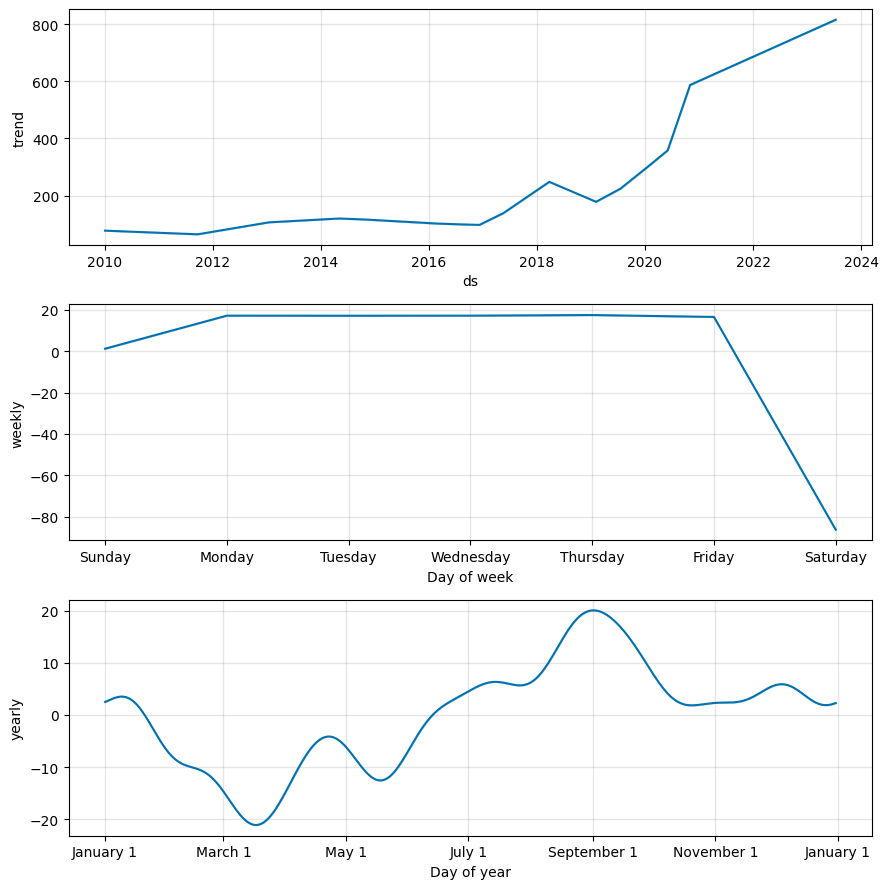

In [15]:
mFullData.plot_components(forecast_full);

In [16]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data

,Date,Open,High,Low,y,Volume,ds
0,2010-01-04,77.434599,78.254013,76.955243,77.782852,952740,2010-01-04
1,2010-01-05,78.254011,86.231004,77.926244,83.813736,7061550,2010-01-05
2,2010-01-06,84.563491,85.907329,82.285522,85.124794,2960980,2010-01-06
3,2010-01-07,86.030254,87.513397,84.645449,85.423889,3807800,2010-01-07
4,2010-01-08,85.792617,88.066491,85.309166,85.849976,2940330,2010-01-08
...,...,...,...,...,...,...,...
3336,2023-07-10,841.500000,841.500000,822.000000,825.650024,1177214,2023-07-10
3337,2023-07-11,826.000000,843.000000,825.750000,840.299988,2167322,2023-07-11
3338,2023-07-12,844.950012,847.799988,838.799988,843.250000,1435731,2023-07-12
3339,2023-07-13,847.000000,849.000000,835.200012,837.349976,985928,2023-07-13


In [17]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)
df_xgb.tail(1)
prophet_variables_full = forecast_full.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb_full = pd.concat([data, prophet_variables_full], axis = 1)
#df_xgb_full.tail(1)
df_xgb_full.tail(1)


,Date,Open,High,Low,y,Volume,ds,trend,weekly,multiplicative_terms
3340,2023-07-14,838.950012,852.75,833.599976,851.5,1704921,2023-07-14,815.681101,16.46855,0.0


#XGBoost preparation

In [18]:
#create training and test set
test_days = 100
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]

In [19]:
#isolate X and y
y_train = training_set.y
y_test = test_set.y 
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]
#full data 
y_train_full = df_xgb_full.y
x_train_full = df_xgb_full.iloc[:, 2:]


In [20]:
x_train_full = x_train_full.drop(columns=["ds"])
X_train = X_train.drop(columns=["ds"])
X_test = X_test.drop(columns=["ds"])
#x_train_full = x_train_full.drop(columns=["ds"])

In [21]:
#Matrices
import xgboost as xgb
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

In [22]:
#Matrices FULL DATA
Train_full = xgb.DMatrix(x_train_full, label = y_train_full)

In [23]:
#set the parameters
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight' : 1,
              'gamma': 0,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

#XGBoost

In [24]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:537.89398
[1]	y-rmse:378.89856
[2]	y-rmse:268.60621
[3]	y-rmse:191.69862
[4]	y-rmse:136.73451
[5]	y-rmse:97.41297
[6]	y-rmse:70.75247
[7]	y-rmse:50.31676
[8]	y-rmse:36.34943
[9]	y-rmse:26.36421
[10]	y-rmse:19.39351
[11]	y-rmse:14.33492
[12]	y-rmse:10.76431
[13]	y-rmse:8.23586
[14]	y-rmse:6.51707
[15]	y-rmse:5.34328
[16]	y-rmse:4.35776
[17]	y-rmse:3.91586
[18]	y-rmse:3.32417
[19]	y-rmse:2.95377
[20]	y-rmse:2.75133
[21]	y-rmse:2.62494
[22]	y-rmse:2.53321
[23]	y-rmse:2.10143
[24]	y-rmse:2.05970
[25]	y-rmse:2.04655
[26]	y-rmse:2.01451
[27]	y-rmse:1.70608
[28]	y-rmse:1.70097
[29]	y-rmse:1.69966
[30]	y-rmse:1.64479
[31]	y-rmse:1.64265
[32]	y-rmse:1.57652
[33]	y-rmse:1.58571
[34]	y-rmse:1.56792
[35]	y-rmse:1.57056
[36]	y-rmse:1.47017
[37]	y-rmse:1.44860
[38]	y-rmse:1.44483
[39]	y-rmse:1.44337


In [25]:
#FULL
model_full = xgb.train(params = parameters,
                  dtrain = Train_full,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:535.99209
[1]	y-rmse:378.93446
[2]	y-rmse:266.79974
[3]	y-rmse:188.98193
[4]	y-rmse:133.12896
[5]	y-rmse:94.38031
[6]	y-rmse:66.34500
[7]	y-rmse:46.83807
[8]	y-rmse:33.35377
[9]	y-rmse:23.60982
[10]	y-rmse:16.74128
[11]	y-rmse:12.02254
[12]	y-rmse:8.67614
[13]	y-rmse:6.32735
[14]	y-rmse:4.70784
[15]	y-rmse:3.68795
[16]	y-rmse:3.01148
[17]	y-rmse:2.48717
[18]	y-rmse:2.24544
[19]	y-rmse:1.92061
[20]	y-rmse:1.77196
[21]	y-rmse:1.59322
[22]	y-rmse:1.58800
[23]	y-rmse:1.47791
[24]	y-rmse:1.46837
[25]	y-rmse:1.33428
[26]	y-rmse:1.34049
[27]	y-rmse:1.23563
[28]	y-rmse:1.23879
[29]	y-rmse:1.19936
[30]	y-rmse:1.30207
[31]	y-rmse:1.23473
[32]	y-rmse:1.23531
[33]	y-rmse:1.23750
[34]	y-rmse:1.35866
[35]	y-rmse:1.25784
[36]	y-rmse:1.25613
[37]	y-rmse:1.21690
[38]	y-rmse:1.22050
[39]	y-rmse:1.38242


In [26]:
Train_full

In [27]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

In [28]:

# Save the trained model to a file
#with open('./TrainedModel/prophet/{}_prophet_model_1.pkl'.format(stock_name), 'wb') as f:
#    pickle.dump(model_full, f)

In [29]:
#f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
#f_predictions

#VIZ and assessment

In [30]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

In [31]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

<Axes: xlabel='ds'>

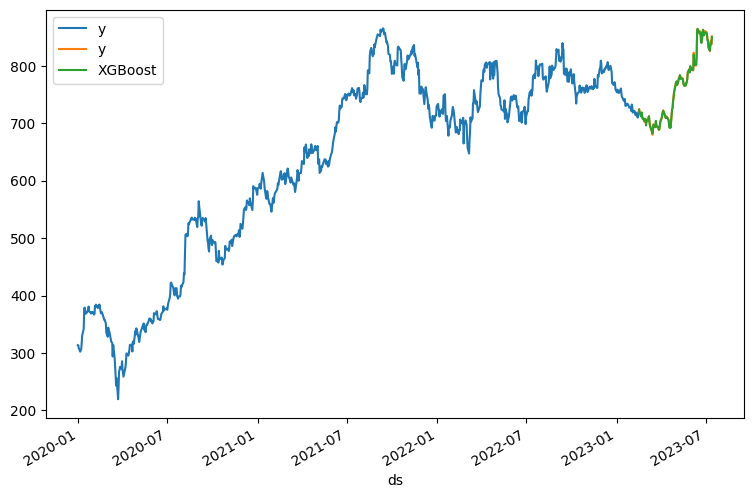

In [32]:
training_set.y['2020-01-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions.plot(legend = True)

In [33]:
#MAPE
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set.y, predictions)

0.14602204668363108

#Future



In [34]:
# Create a dictionary with data
data = {
            'High': [4.123123],
    'Low': [4.123123],
    'y': [210.935516],
    'Volume': [4.123123],
        'trend': [8.12313],
        'weekly': [4.123123],
            'multiplicative_terms': [4.444],
                

                
                }

# Create a new DataFrame object
df = pd.DataFrame(data)


In [35]:
Future = xgb.DMatrix(df, label = df.y)
f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
f_predictions

0    190.656113
Name: XGBoost, dtype: float32